In [ ]:
from openbb import obb
import yfinance as yf
import numpy as np
import pandas as pd
from datetime import datetime
from scipy.optimize import brentq
from scipy.stats import norm, gaussian_kde
from scipy.interpolate import splrep, BSpline
from scipy.integrate import simpson
import plotly.graph_objects as go

# EUROPEAN OPTIONS ONLY
tickerSymbol = "SPY"
expir_date_number = 1

min_volume = 20         # Minimum volume for options liquidity
max_spread_ratio = 0.3  # Max acceptable bid-ask spread ratio

chain_raw = obb.derivatives.options.chains(
    tickerSymbol,
    source="YahooFinance",
)

# Fetch the stock data from yfinance
ticker = yf.Ticker(tickerSymbol)
# Get current stock price
current_price = ticker.history(period="1d")['Close'][-1]
# list of expiration dates
expirations = ticker.options

df_options = chain_raw.to_df()
print(df_options)
print(df_options.columns)


    underlying_symbol  underlying_price      contract_symbol  expiration  dte  \
0                SHEL             73.42  SHEL251212C00040000  2025-12-12    4   
1                SHEL             73.42  SHEL251212P00040000  2025-12-12    4   
2                SHEL             73.42  SHEL251212C00045000  2025-12-12    4   
3                SHEL             73.42  SHEL251212P00045000  2025-12-12    4   
4                SHEL             73.42  SHEL251212C00050000  2025-12-12    4   
..                ...               ...                  ...         ...  ...   
845              SHEL             73.42  SHEL280121P00100000  2028-01-21  774   
846              SHEL             73.42  SHEL280121C00105000  2028-01-21  774   
847              SHEL             73.42  SHEL280121P00105000  2028-01-21  774   
848              SHEL             73.42  SHEL280121C00110000  2028-01-21  774   
849              SHEL             73.42  SHEL280121P00110000  2028-01-21  774   

     strike option_type  op

C:\Users\piotr\AppData\Local\Temp\ipykernel_20116\1498588677.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  current_price = ticker.history(period="1d")['Close'][-1]


In [115]:
table = df_options[df_options['expiration'].astype(str) == expirations[expir_date_number]]
table = table[['strike', 'last_trade_price', 'bid', 'ask', 'volume', 'theoretical_price', 'implied_volatility', 'expiration']]
table = table[table['volume'] >= min_volume]
table = table[(table['ask'] - table['bid']) / table['ask'] <= max_spread_ratio]

df_options["expiration"] = pd.to_datetime(df_options["expiration"])
table['expiration'] = pd.to_datetime(table['expiration'])

table["ttm"] = (table["expiration"] - datetime.now()).dt.days / 365.25
print(table)





     strike  last_trade_price   bid   ask  volume  theoretical_price  \
107    72.5              0.68  0.65  0.75      57             0.7068   
110    74.0              0.90  0.55  0.65      20             0.5635   
112    75.0              0.34  0.30  0.35     164             0.3031   

     implied_volatility expiration       ttm  
107              0.1700 2025-12-19  0.027379  
110              0.1705 2025-12-19  0.027379  
112              0.1722 2025-12-19  0.027379  


In [87]:
import pandas_datareader.data as web
import datetime as dt

start = dt.datetime(2015, 1, 1)
end = dt.datetime.today()

series = {
    "1m": "DGS1MO",
    "3m": "DGS3MO",
    "6m": "DGS6MO",
    "1y": "DGS1",
    "2y": "DGS2",
    "3y": "DGS3"
}

tenor_years = {
    "1m": 1/12,
    "3m": 3/12,
    "6m": 6/12,
    "1y": 1,
    "2y": 2,
    "3y": 3
}

def get_best_treasury_maturity(ttm):
    diffs = {k: abs(v - ttm) for k, v in tenor_years.items()}
    return min(diffs, key=diffs.get)

rates = {}

for name, fred_code in series.items():
    rates[name] = web.DataReader(fred_code, "fred", start, end)

df_rates = pd.concat(rates, axis=1)

last_rates = df_rates.iloc[-1]
print(last_rates)
table['rate'] = table['ttm'].apply(lambda ttm: last_rates[get_best_treasury_maturity(ttm)])
print(table)


1m  DGS1MO    3.83
3m  DGS3MO    3.71
6m  DGS6MO    3.69
1y  DGS1      3.60
2y  DGS2      3.52
3y  DGS3      3.55
Name: 2025-12-04 00:00:00, dtype: float64
     strike  last_trade_price   bid   ask  volume  theoretical_price  \
347    35.0              0.67  0.66  0.72     705             0.6855   
348    36.0              1.13  1.05  1.14      74             1.0987   
349    36.0              1.00  1.05  1.15      77             1.1019   
350    37.0              0.70  0.64  0.71     469             0.6809   
351    37.0              1.28  1.57  1.78      32             1.6950   
352    38.0              0.41  0.36  0.42     296             0.4091   

     implied_volatility expiration       ttm  rate  
347              0.2336 2026-01-16  0.104038  3.83  
348              0.2238 2026-01-16  0.104038  3.83  
349              0.2252 2026-01-16  0.104038  3.83  
350              0.2215 2026-01-16  0.104038  3.83  
351              0.2194 2026-01-16  0.104038  3.83  
352              0.22

In [88]:
from scipy.optimize import brentq
from scipy.stats import norm


# Black-Scholes Call Option Pricing
def call_bs_price(S, K, T, r, sigma):
    if T <= 0:
        return max(S - K, 0)

    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    return price


# Function to calculate implied volatility
def implied_vol_call(price, S, K, T, r):
    if T <= 0 or price <= 0:
        return np.nan

    def objective(sigma):
        return call_bs_price(S, K, T, r, sigma) - price

    try:
        implied_vol = brentq(objective, 1e-9, 5.0)
        return implied_vol
    except ValueError:
        return np.nan


# Define variables
T = (pd.to_datetime(expirations[expir_date_number]) - pd.Timestamp.today()).days / 365.25
S = ticker.history().iloc[-1]['Close']
r = float(last_rates[get_best_treasury_maturity(T)]) / 100  # Convert percentage to decimal
# Calculate implied volatilities for all call options
table['manual_iv'] = table.apply(
    lambda row: implied_vol_call(row['last_trade_price'], S, row['strike'], T, r), axis=1
)

# Drop rows where implied volatility couldn't be calculated
table.dropna(subset=['manual_iv'], inplace=True)

# Check calculated implied volatilities
table
#table.shape

C:\Users\piotr\AppData\Local\Temp\ipykernel_20116\4192696155.py:35: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  r = float(last_rates[get_best_treasury_maturity(T)]) / 100  # Convert percentage to decimal


,strike,last_trade_price,bid,ask,volume,theoretical_price,implied_volatility,expiration,ttm,rate,manual_iv
348,36.0,1.13,1.05,1.14,74,1.0987,0.2238,2026-01-16,0.104038,3.83,0.237279
349,36.0,1.00,1.05,1.15,77,1.1019,0.2252,2026-01-16,0.104038,3.83,0.209103
350,37.0,0.70,0.64,0.71,469,0.6809,0.2215,2026-01-16,0.104038,3.83,0.235491
351,37.0,1.28,1.57,1.78,32,1.6950,0.2194,2026-01-16,0.104038,3.83,0.364113
352,38.0,0.41,0.36,0.42,296,0.4091,0.2223,2026-01-16,0.104038,3.83,0.235747


In [ ]:
#SPLINE CREATION
from scipy.interpolate import splrep, BSpline

# Use strikes and implied volatilities calculated previously
strikes = table['strike'].values
ivs = table['manual_iv'].values
ttm = table['ttm'].values[0]
smoothing = 5 + ttm * 1000/table.shape[0]
smoothing = smoothing
print(f"smoothing factor: {smoothing}")
# Fit a spline to implied vol data
# s is the smoothing factor, generally set to the data size level
iv_spline_tck = splrep(strikes, ivs, s=smoothing, k=3)

# Define strike grid for smooth PDF
K_grid = np.linspace(strikes.min(), strikes.max(), 300)

smoothing factor: 50


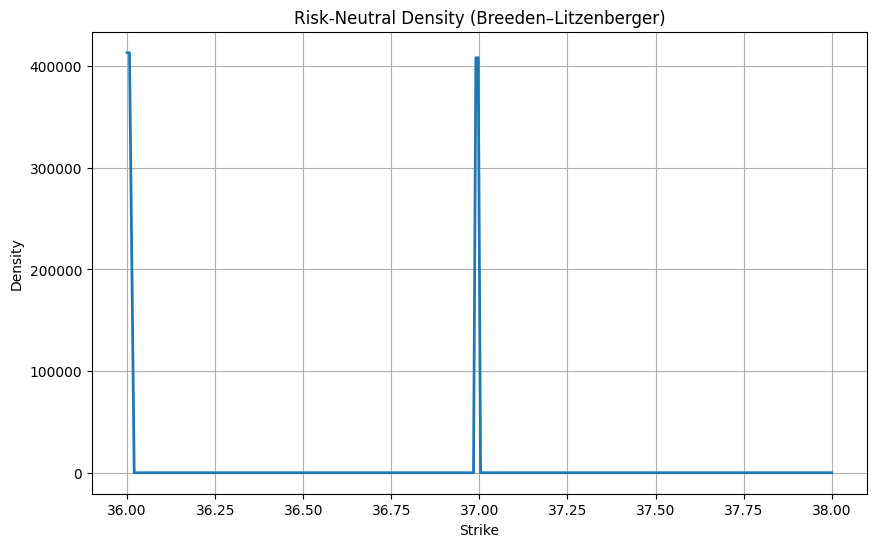

In [93]:
# SECOND DERIVATIVE and PDF

from scipy.interpolate import BSpline


# Function to build the PDF
def build_pdf(K_grid, iv_spline_tck, S, T, r):
    # Calculate implied volatilities across the strike grid
    iv_vals = BSpline(*iv_spline_tck)(K_grid)

    # Compute Black-Scholes call prices at each strike
    call_prices = np.array([call_bs_price(S, K, T, r, iv) for K, iv in zip(K_grid, iv_vals)])

    # Calculate second derivative numerically
    first_derivative = np.gradient(call_prices, K_grid)
    second_derivative = np.gradient(first_derivative, K_grid)

    # Calculate raw PDF using Breeden-Litzenberger formula
    pdf_raw = np.exp(r * T) * second_derivative

    # Ensure PDF is non-negative
    pdf_raw = np.clip(pdf_raw, 0, None)

    return K_grid, pdf_raw

K_grid, pdf_raw = build_pdf(K_grid, iv_spline_tck, S, T, r)

import matplotlib.pyplot as plt
# Plot the resulting PDF

plt.figure(figsize=(10,6))
plt.plot(K_grid, pdf_raw, linewidth=2)
plt.title("Risk-Neutral Density (Breeden–Litzenberger)")
plt.xlabel("Strike")
plt.ylabel("Density")
plt.grid(True)
plt.show()


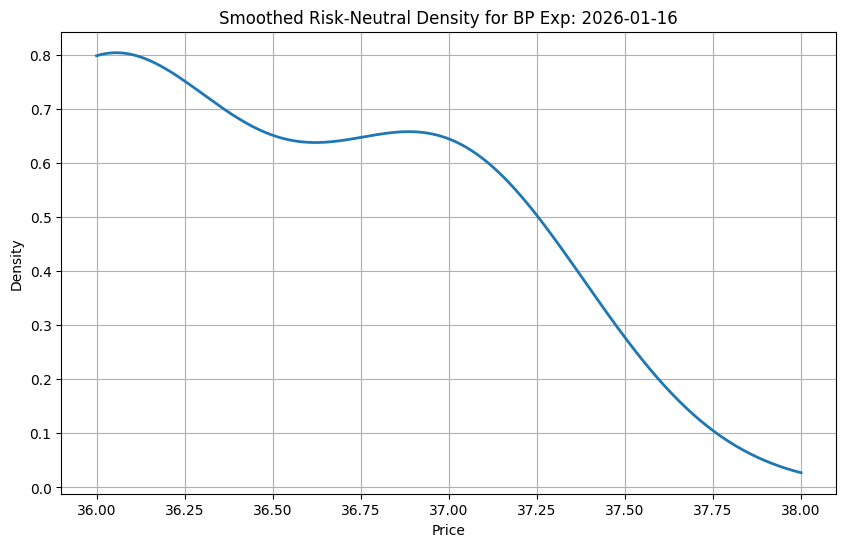

Expected value: 36.73059915889767
Current stock price: 35.92499923706055
percent difference: 2.24%
number of datapoints: 5


In [91]:
from scipy.stats import gaussian_kde

def smooth_pdf(K_grid, pdf_raw):
    # Smooth PDF using Gaussian KDE
    kde = gaussian_kde(K_grid, weights=pdf_raw)
    pdf_smooth = kde(K_grid)

    # Normalize the PDF to integrate to 1
    area = np.trapezoid(pdf_smooth, K_grid)
    if area > 0:
        pdf_smooth /= area

    return pdf_smooth

# Apply smoothing
pdf_smooth = smooth_pdf(K_grid, pdf_raw)

plt.figure(figsize=(10,6))
plt.plot(K_grid, pdf_smooth, linewidth=2)
plt.title(f"Smoothed Risk-Neutral Density for {tickerSymbol} Exp: {expirations[expir_date_number]}")
plt.xlabel("Price")
plt.ylabel("Density")
plt.grid(True)
plt.show()
def expected_value(K_grid, pdf_smooth):
    # Ensure pdf integrates to 1
    pdf_smooth = pdf_smooth / np.trapezoid(pdf_smooth, K_grid)

    # Compute E[K] = ∫ K f(K) dK
    return np.trapezoid(K_grid * pdf_smooth, K_grid)

EV = expected_value(K_grid, pdf_smooth)
print("Expected value:", EV)
print("Current stock price:", S)
print(f"percent difference: {((EV - S) / S * 100):.2f}%")
print("number of datapoints:", table.shape[0])
